# Compare hexbin maps of MERRA-2 SMB anomaly (%) and ICESat-2 deltaH over May 1st, 2019 - August 1st, 2019

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import geopandas as gpd

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr
from scipy import interpolate
from palettable.colorbrewer.diverging import *
from palettable.cmocean.sequential import *

# Miscalaneous

In [2]:
# Define time
t0 = "2019-05-01"
tf = "2019-08-01"

# Get Antarctic coastlines data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Functions

In [3]:
def time_str_datetime(time_str):
    t = pd.Series(pd.date_range(time_str, periods=1, freq='D'))
    t = datetime.strptime(np.datetime_as_string(t, unit='D')[0], '%Y-%m-%d')
    return t

def convert_lat_lon_to_epsg3031(lon, lat):
    
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo
    
    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)

    # Initialize arrays
    x = np.zeros(len(lon)); x[:] = np.nan
    y = np.zeros(len(lat)); y[:] = np.nan

    # Perform transformation
    for j in range(0, len(x)):
        coords = transform.TransformPoint(lat[j], lon[j])
        x[j], y[j] = coords[0:2]
    
    return x, y

def get_M2_smb(t0, tf):
    '''
    Calculate accumulated MERRA-2 SMB between two times in units of kg/m^2
    '''
    ds = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
    ais_mask = xr.open_dataset("/pl/active/nasa_smb/Data/AIS_basins_Zwally_MERRA2grid.nc")
    ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
    ind0 = ds.indexes["time"].get_loc(t0,  method="nearest")
    indf = ds.indexes["time"].get_loc(tf,  method="nearest")
    smb = ds["__xarray_dataarray_variable__"][ind0:indf,:,:].sum(dim='time')
    smb = smb * ais_mask
    
    lon = smb['lon'].values
    lat = smb['lat'].values
    lon, lat = np.meshgrid(lon, lat)
    x, y = convert_lat_lon_to_epsg3031(lon.flatten(), lat.flatten())
    smb = smb.values.flatten()
    
    return smb, x, y

def daily_climatology(ds):
    day = ds['time.dayofyear']
    day.name = 'day'
    return ds.groupby(day).mean('time')

def get_M2_smb_climatology(t0, tf):
    ais_mask = xr.open_dataset("/pl/active/nasa_smb/Data/AIS_basins_Zwally_MERRA2grid.nc")
    ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
    ds = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
    smb_daily_climatology = ds.apply(daily_climatology)
    mean_smb = smb_daily_climatology["__xarray_dataarray_variable__"][t0.timetuple().tm_yday:tf.timetuple().tm_yday,:,:].sum(dim='day')
    mean_smb = mean_smb * ais_mask
    mean_smb = mean_smb.values.flatten()
    return mean_smb

def plot_hexbin(x, y, C, nbins, extent, colormap, label, vmin="", vmax=""):
    
    # Generate figure 
    fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                            figsize=(12, 12))

    # Plot hexbin
    if type(vmin) == float and type(vmax) == float:
        hb = axs.hexbin(x, y, C=C, reduce_C_function=np.median, gridsize=nbins, extent=extent, cmap=colormap, alpha=1, vmin=vmin, vmax=vmax)
    else:
        hb = axs.hexbin(x, y, C=C, reduce_C_function=np.median, gridsize=nbins, extent=extent, cmap=colormap, alpha=1)
    
    cbar = plt.colorbar(hb, ax=axs, orientation='horizontal')
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label(label, size=32)

    # Plot coastlines
    axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
    axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                          facecolor='none', edgecolor='black')
    
    return hb

# Get MERRA-2 SMB from May 1st, 2019 - August 1st, 2019

In [4]:
# Define time
t0 = time_str_datetime(t0)
tf = time_str_datetime(tf)

smb, x, y = get_M2_smb(t0, tf)

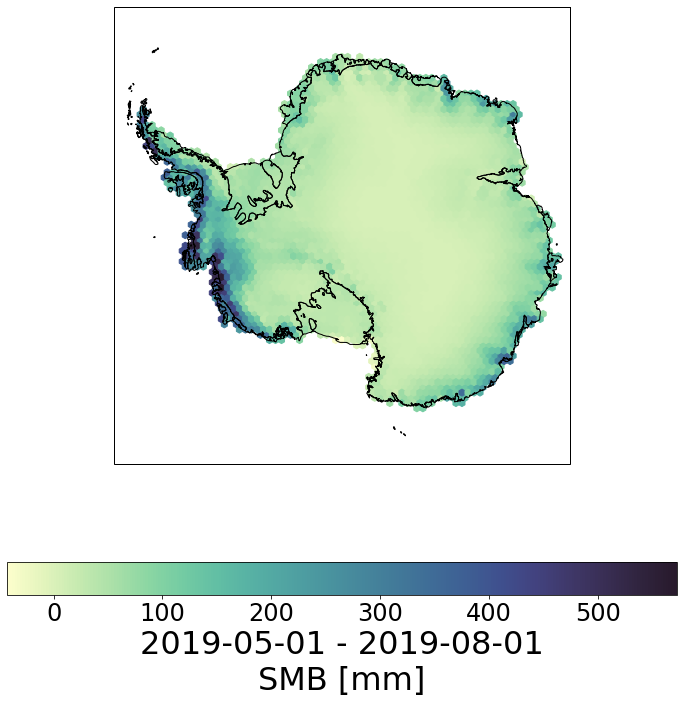

In [5]:
nbins = 75
extent = (-2800e3, 2800e3, -2800e3, 2800e3)
label = str(t0)[0:10] + " - " + str(tf)[0:10] + "\nSMB [mm]"
plot_hexbin(x, y, smb, nbins, extent, Deep_20.mpl_colormap, label)

# Average 1980 - 2020 SMB over the period 

In [6]:
# Calculate daily mean SMB
mean_smb = get_M2_smb_climatology(t0, tf)

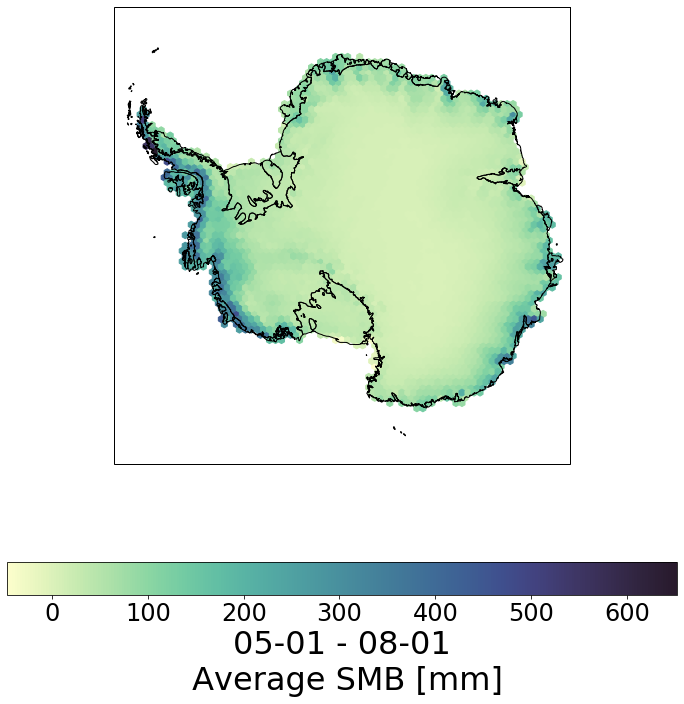

In [7]:
label = str(t0)[5:10] + " - " + str(tf)[5:10] + "\n Average SMB [mm]"
plot_hexbin(x, y, mean_smb, nbins, extent, Deep_20.mpl_colormap, label)

# Make anomaly plot

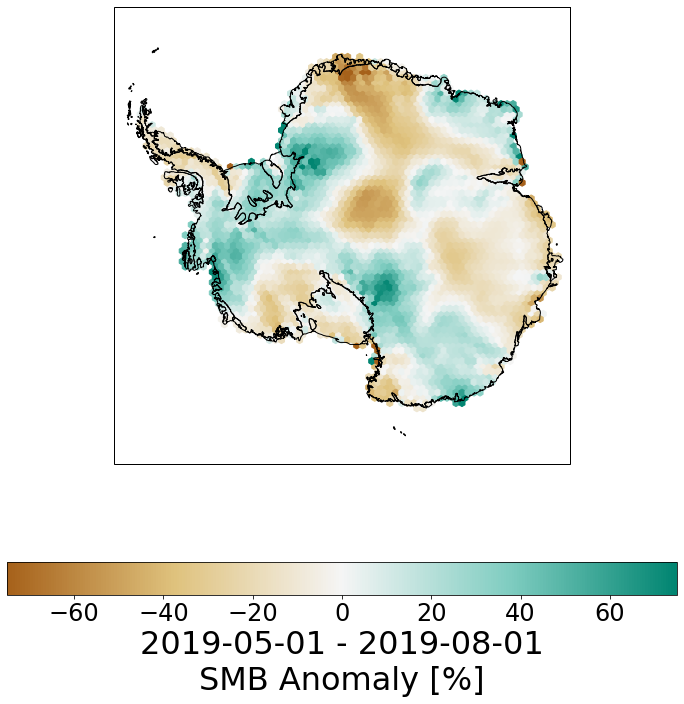

In [8]:
anomaly = (smb - mean_smb) / mean_smb * 100
label = str(t0)[0:10] + " - " + str(tf)[0:10] + "\nSMB Anomaly [%]"
anomaly_hb = plot_hexbin(x, y, anomaly, nbins, extent, BrBG_5.mpl_colormap, label, -75.0, 75.0)

# Make a delta height map

In [9]:
src_path = "../data/pt1_ATL11_081111_0309_003_01.nc" # Option 1, low SNR
ds_ATL11 = xr.open_dataset(src_path)
ds_ATL11

<xarray.Dataset>
Dimensions:                  (cycle: 7, x: 40584, y: 40584)
Coordinates:
  * y                        (y) float64 -2.304e+05 -2.304e+05 ... 5.98e+05
  * cycle                    (cycle) int64 1 2 3 4 5 6 7
  * x                        (x) float64 1.176e+06 1.176e+06 ... -1.038e+06
Data variables:
    Height                   (y, cycle) float32 ...
    Height_Sigma             (y, cycle) float32 ...
    Height_Sigma_Systematic  (y, cycle) float32 ...
    Time                     (y, cycle) float64 ...

In [10]:
h0 = ds_ATL11['Height'][:,0]
hf = ds_ATL11['Height'][:,1]
h0[h0 < 200] = np.nan
dh = hf - h0
dh = dh * 100 # Convert units from meters to cm.
x = ds_ATL11['x'].values
y = ds_ATL11['y'].values

In [11]:
h0.shape

(40584,)

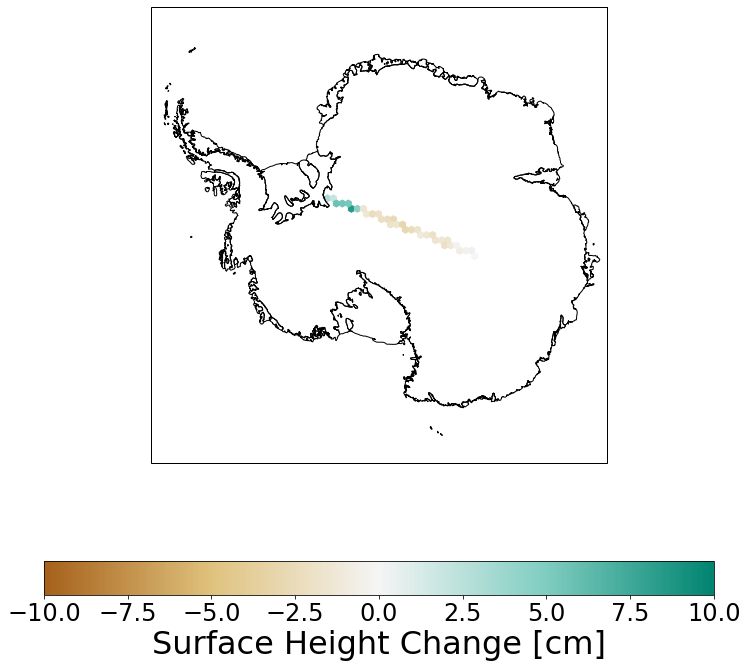

In [12]:
label = "Surface Height Change [cm]"
dh_hb = plot_hexbin(x, y, dh, nbins, extent, BrBG_5.mpl_colormap, label, -10.0, 10.0)

# Make a scatter plot of SMB anomaly vs surface height change

In [13]:
# Define Y value of scatter plot
y = dh_hb.get_array()
x = np.zeros(len(y)); x[:] = np.nan

# Define number of points
n = len(y)

In [14]:
# Loop through each index of IC2, and find the corresponding indices of M2
for j in range(0, n):
    for k in range(0, anomaly_hb.get_offsets().shape[0]):
        if dh_hb.get_offsets()[j, 0] == anomaly_hb.get_offsets()[k, 0] and dh_hb.get_offsets()[j, 1] == anomaly_hb.get_offsets()[k, 1]:
            x[j] = anomaly_hb.get_array()[k]
            break

Text(0.5, 1.0, 'Slope = 0.09303730844779946\nR^2 = 0.5082154054276652,\np = 3.2380585032494447e-06')

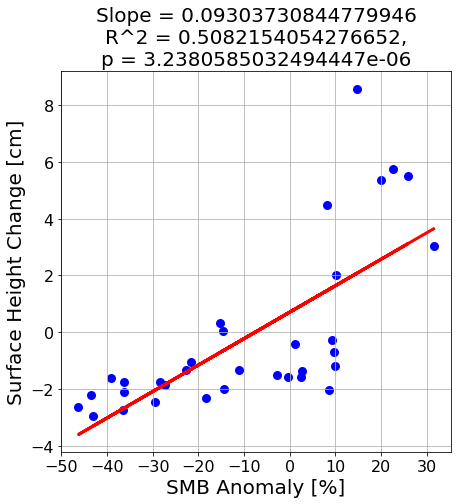

In [15]:
lin_reg = stats.linregress(x, y)

plt.figure(figsize=(7, 7))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
plt.grid()
plt.xlabel("SMB Anomaly [%]", fontsize=20)
plt.ylabel("Surface Height Change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue), \
         fontsize=20)